In [1]:
#  Import des librairies
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
#  Charger les données et préparer les features
df = pd.read_csv("features_log.csv")

cols_to_drop = [col for col in ["timestamp", "gaze", "anomaly"] if col in df.columns]
features = df.drop(columns=cols_to_drop).values

def create_sequences(data, seq_length=60):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

sequences = create_sequences(features, seq_length=60)

print(f"Forme des séquences : {sequences.shape}")


Forme des séquences : (4830, 60, 12)


In [3]:
#  Standardiser les données et split train/test
n_samples, timesteps, n_features = sequences.shape
sequences_reshaped = sequences.reshape(-1, n_features)

scaler = StandardScaler()
sequences_scaled = scaler.fit_transform(sequences_reshaped)

sequences_scaled = sequences_scaled.reshape(n_samples, timesteps, n_features)

X_train, X_test = train_test_split(sequences_scaled, test_size=0.2, random_state=42)


In [4]:
# Construction du modèle RNN autoencodeur
inputs = Input(shape=(timesteps, n_features))

encoded = SimpleRNN(64, return_sequences=True)(inputs)
encoded = Dropout(0.2)(encoded)
encoded = SimpleRNN(32)(encoded)
encoded = Dropout(0.2)(encoded)

encoded = Dense(16, activation='relu')(encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = SimpleRNN(32, return_sequences=True)(decoded)
decoded = Dropout(0.2)(decoded)
decoded = SimpleRNN(64, return_sequences=True)(decoded)
decoded = Dropout(0.2)(decoded)

outputs = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 60, 64)         │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 60, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 60, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 12)         │           780 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,116 (66.86 KB)

 Trainable params: 17,116 (66.86 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#  Entraînement avec early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, X_test),
    callbacks=[early_stop]
)


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - loss: 0.9460 - val_loss: 0.4242
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.5628 - val_loss: 0.3463
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.4450 - val_loss: 0.2997
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.3946 - val_loss: 0.2755
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.3501 - val_loss: 0.2540
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.3358 - val_loss: 0.2466
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.3245 - val_loss: 0.2328
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.3177 - val_loss: 0.2350
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.3027 - val_loss: 0.2186
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.2873 - val_loss: 0.2096
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.2601 - val_loss: 0.2120
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/ste

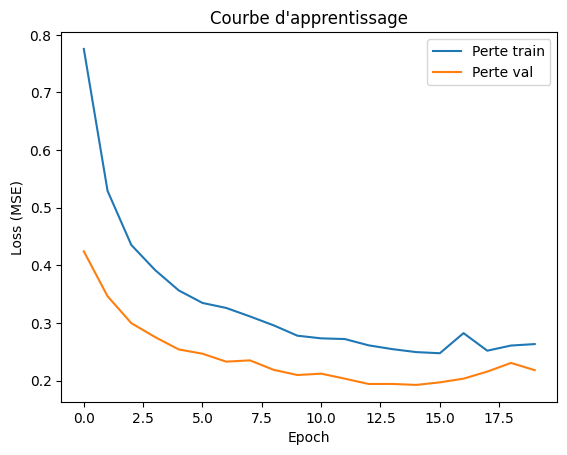

In [6]:
# Visualisation de la courbe d'apprentissage
plt.plot(history.history['loss'], label='Perte train')
plt.plot(history.history['val_loss'], label='Perte val')
plt.title('Courbe d\'apprentissage')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [7]:
#  Détection d'anomalies
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=(1,2))

threshold = np.percentile(mse, 95)
anomalies = mse > threshold

print(f"Nombre d'anomalies détectées : {np.sum(anomalies)}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
Nombre d'anomalies détectées : 49


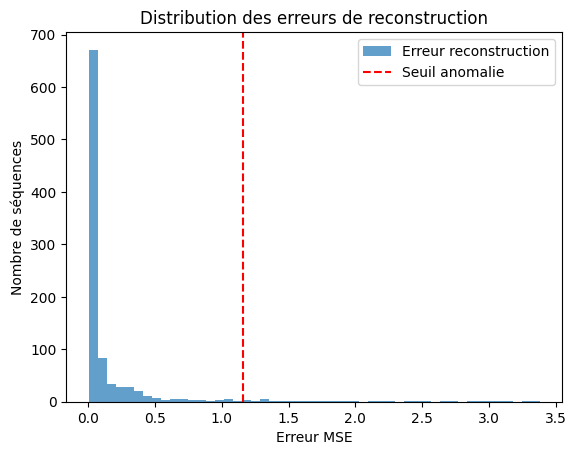

In [8]:
#  Visualisation distribution des erreurs
plt.hist(mse, bins=50, alpha=0.7, label='Erreur reconstruction')
plt.axvline(threshold, color='r', linestyle='--', label='Seuil anomalie')
plt.legend()
plt.title("Distribution des erreurs de reconstruction")
plt.xlabel("Erreur MSE")
plt.ylabel("Nombre de séquences")
plt.show()
